<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/RedNeuronalDensa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Densas
### Feed Forward Neural Network
Análisis de Sentimientos sobre un conjunto de tweets

---
# Conjunto de datos
Cargar el dataset [text_emotion.csv](https://github.com/orlandxrf/curso-dl/blob/main/data/text_emotion.csv)

In [1]:
from google.colab import drive
# !pip install -U pandas # actualizar biblioteca
import pandas as pd

drive.mount('/content/drive')
df = pd.read_csv('drive/My Drive/Colab Notebooks/text_emotion.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Explorar el conjunto de datos

In [2]:
df

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


1	8638	neutral
2	8459	worry
3	5209	happiness
4	5165	sadness
5	3842	love
6	2187	surprise
7	1776	fun
8	1526	relief
9	1323	hate
10	827	empty
11	759	enthusiasm
12	179	boredom
13	110	anger


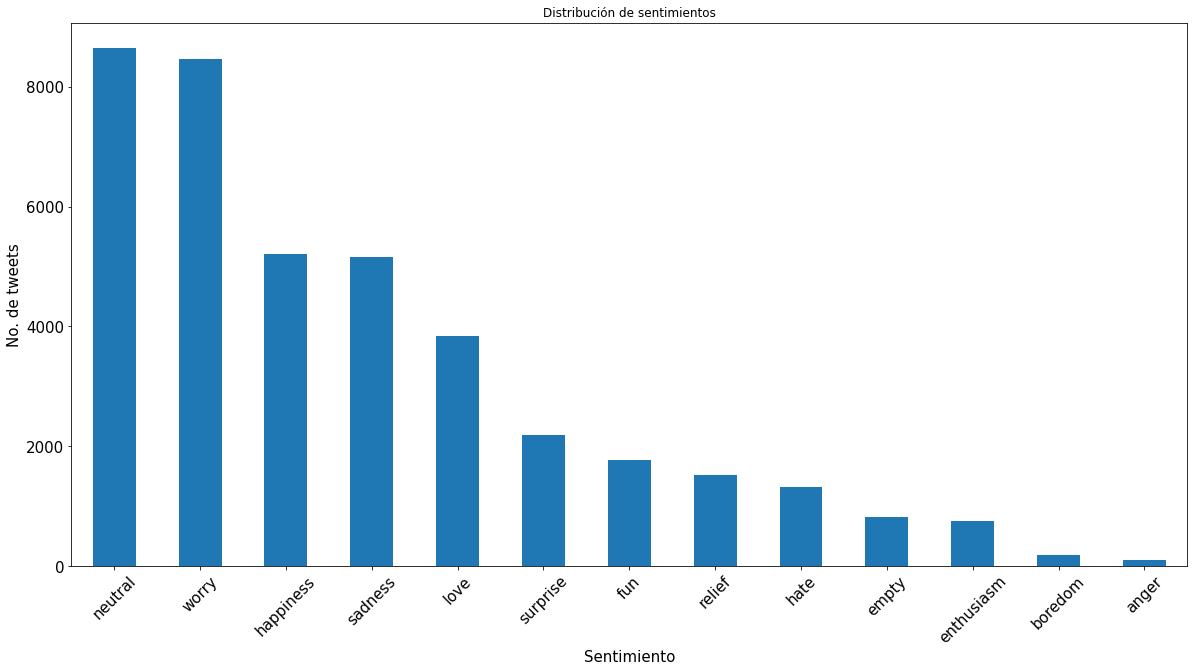

In [3]:
# visualizar datos
# !pip install -U matplotlib
import matplotlib.pyplot as plt

sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")

# Graficar la distribución
plt.figure(figsize=(20, 10))
pd.value_counts(df['sentiment']).plot.bar(title="Distribución de sentimientos")
plt.xlabel("Sentimiento", fontsize="15")
plt.ylabel("No. de tweets", fontsize="15")
plt.xticks(rotation=45, fontsize="15")
plt.yticks(fontsize="15")
plt.show()

# Preprocesamiento del dataset

## 1. Limpieza
Remover URLs de todos los tweets

In [4]:
import re
count_empty = 0
for i, row in df.iterrows():
  clean_tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", row['content'])
  clean_tweet = re.sub(r"#\w+ ?", "", clean_tweet)
  clean_tweet = ' '.join(clean_tweet.lower().split())
  if len(clean_tweet) == 0:
    # remover tweets que al ser limpiados no contienen nada
    # print (f"{i}\t{row['sentiment']}\t{row['content']}")
    count_empty += 1
    df.drop(df.index[[i]], inplace=True) # inplace=True --> no devuleve valores
  else:
    # reemplazar tweet limpio en el dataset
    df.at[i, 'content'] = clean_tweet

print (f"{count_empty} tweets vacíos despues de la limpieza\n")

# revisar nuevamente el dataset limpio
sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")


82 tweets vacíos despues de la limpieza

1	8621	neutral
2	8442	worry
3	5195	happiness
4	5159	sadness
5	3835	love
6	2186	surprise
7	1771	fun
8	1522	relief
9	1322	hate
10	824	empty
11	755	enthusiasm
12	177	boredom
13	110	anger


## 2. Seleccionar datos balanceados
El dataset está desbalanceado. Seleccionar clases (sentimientos) para obtener un nuevo dataset balanceado

In [5]:
exclude = ['anger','boredom','enthusiasm','empty'] # clases menores a 1000

n_tweets = 1000 # cantidad de tweets a filtrar
seed = 22 # fijar estado aleatorio

# filtrar 'neutral'
df_filtered = df[df['sentiment'] == 'neutral'].sample(n=n_tweets, random_state=seed)

for cl in classes:
  if cl not in exclude and cl != 'neutral': # ya se ha filtrado 'neutral'
    df_filtered = pd.concat( [df_filtered, df[df['sentiment'] == cl].sample(n=n_tweets, random_state=seed)] )

# crear diccionario de valores
tags_values = pd.value_counts(df_filtered['sentiment']).to_dict()

print ( pd.value_counts(df_filtered['sentiment']) )

neutral      1000
happiness    1000
love         1000
worry        1000
sadness      1000
surprise     1000
hate         1000
fun          1000
relief       1000
Name: sentiment, dtype: int64


## 3. Remover palabras vacías (stop words)
Es el nombre que se le asigna a las palabras que son comúnmente usadas además de no ser relevantes o carecen de significado en diferentes tareas del PLN. 
<br><br>
Instalar la biblioteca [Spacy](https://spacy.io/usage)

In [6]:
# Instalar Spacy
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_sm # descargar el modelo a utilizar

import spacy
# cargar el modelo de lenguaje de Spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
print (f"Stop words {len(stopwords)}")



Stop words 326


## 4. Tokenización
En este proceso se divide el texto (oración) del tweet en un vector de tokens. Los tokens pueden ser palabras, números, símbolos, signos de puntuación, etc.

In [7]:
# tokenización con Spacy
# utilizar el modelo cargado en la variable nlp
# !pip install tqdm # para visualizar progreso
from tqdm.auto import tqdm

for i, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Tokenización de tweets"):
  doc = nlp(row['content'])
  df_filtered.at[i, 'content'] = [token.text for token in doc]


Tokenización de tweets:   0%|          | 0/9000 [00:00<?, ?it/s]

# Crear conjunto de entrenamiento (train) y conjunto de prueba (test)

Agregar una columna al `dataFrame` que indique el id de cadada clase `sentiment`

In [8]:
tags_values = dict(sorted(tags_values.items(), key=lambda k:k[0], reverse=False))
print (tags_values)
tags = {x:i for i, x in enumerate(tags_values)}

for tag in tags:
  print (f'Remplazando "{tag}" por "{tags[tag]}"')
  df_filtered['sentiment'] = df_filtered['sentiment'].replace(tag, str(tags[tag]))

# cambiar el tipo de valor de la columna sentiment
df_filtered['sentiment'] = pd.to_numeric(df_filtered['sentiment'])

print (f'\n{tags}')
print ( pd.value_counts(df_filtered['sentiment']) )

{'fun': 1000, 'happiness': 1000, 'hate': 1000, 'love': 1000, 'neutral': 1000, 'relief': 1000, 'sadness': 1000, 'surprise': 1000, 'worry': 1000}
Remplazando "fun" por "0"
Remplazando "happiness" por "1"
Remplazando "hate" por "2"
Remplazando "love" por "3"
Remplazando "neutral" por "4"
Remplazando "relief" por "5"
Remplazando "sadness" por "6"
Remplazando "surprise" por "7"
Remplazando "worry" por "8"

{'fun': 0, 'happiness': 1, 'hate': 2, 'love': 3, 'neutral': 4, 'relief': 5, 'sadness': 6, 'surprise': 7, 'worry': 8}
7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
1    1000
8    1000
0    1000
Name: sentiment, dtype: int64


In [9]:
# !pip install -U scikit-learn
# Utilizar la biblioteca de scikit-learn
from sklearn.model_selection import train_test_split

shuffle = True # Mezclar o no los datos antes de dividir
seed = 40 # Controla la mezcla que se le aplica a los datos antes de aplicar la división
test_size = 0.3 # representan la proporción del conjunto de datos para incluir en la división de prueba

# print (f"Columnas: {df_filtered.columns.values}")

X_train, X_test, Y_train, Y_test = train_test_split(df_filtered[['sentiment', 'content']], df_filtered[['sentiment', 'content']], shuffle=shuffle, test_size=test_size, random_state=seed)

# eliminar indexes anteriores y generar nuevos consecutivos
# drop=True --> para evitar que el índice antiguo se agregue como una columna

print("Conteo de valores para el Train")
print(f"{pd.value_counts(Y_train['sentiment'])}\n")

print("Conteo de valores para el Test")
print(f"{pd.value_counts(Y_test['sentiment'])}\n")

X_train = X_train.reset_index(drop=True)
Y_train = X_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

print (X_test.columns.values)
print (Y_train.columns.values)
print (X_test.columns.values)
print (Y_test.columns.values)

Conteo de valores para el Train
8    723
1    714
3    703
4    701
0    698
2    695
5    690
7    688
6    688
Name: sentiment, dtype: int64

Conteo de valores para el Test
7    312
6    312
5    310
2    305
0    302
4    299
3    297
1    286
8    277
Name: sentiment, dtype: int64

['sentiment' 'content']
['sentiment' 'content']
['sentiment' 'content']
['sentiment' 'content']


# FFNN
**nn()** Las redes neuronales se pueden construir usando `torch.nn`. El módulo `nn.Module` contiene `layers` y un método `forward` (hacia adelante).
<br><br>
**optim()** Implementa los parámetros del modelo que deben optimizarse y los parámetros relacionados con la optimización, como la tasa de aprendizaje, la disminución del peso, etc.
<br><br>
**autograd()** Diferenciación automática, es un método que se usa en la red neuronal, debe calcular los gradientes y esto ahorra un número de operaciones, ya que registra las operaciones realizadas y las reproduce para calcular los gradientes.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Usar CUDA si es que se tiene
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo disponible:\t{device}")


Dispositivo disponible:	cpu


### Definir la FFNN
El modelo FFNN es la forma más simple de red neuronal artificial. La información fluye en una dirección desde la primera capa de entrada, después hacia la capa oculta para continuar a la capa de salida. 

La capa de salida en para una tarea de clasificación es del mismo tamaño que la del número de clases, por ello la capa de salida tendrá 9 categorías, clases o tags:

`tags = {'fun': 0, 'happiness': 1, 'hate': 2, 'love': 3, 'neutral': 4, 'relief': 5, 'sadness': 6, 'surprise': 7, 'worry': 8}`

Para está tarea las capas ocultas seran de 64. Puede usar diferentes funciones de activación, aquí se usa nn.Relu. Softmax se utiliza para la última capa. Puede crear una red personalizada con diferentes funciones y diferentes capas ocultas para ver cuál se ajusta a los datos de entrada dados. Comencemos por definir la red.

In [11]:
class FeedForwadNN(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    # Linear function 1: vocab_size --> 500
    # definir la capa de entrada
    self.fc1 = nn.Linear(input_dim, hidden_dim) 
    # establecer una función de activación ReLU
    self.relu1 = nn.ReLU()
        
    # Linear function 2: 500 --> 500
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    # Non-linearity 2
    self.relu2 = nn.ReLU()
   
    # Linear function 3 (readout): 500 --> 3
    self.fc3 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # Linear function 1
    out = self.fc1(x)
    # Non-linearity 1
    out = self.relu1(out)

    # Linear function 2
    out = self.fc2(out)
    # Non-linearity 2
    out = self.relu2(out)

    # Linear function 3 (readout)
    out = self.fc3(out)

    return F.softmax(out, dim=1)

model = FeedForwadNN(500, 500, 9)
print (model)

# !pip install -U torchinfo
from torchinfo import summary
print ( summary(model) )

FeedForwadNN(
  (fc1): Linear(in_features=500, out_features=500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=500, out_features=9, bias=True)
)
Layer (type:depth-idx)                   Param #
FeedForwadNN                             --
├─Linear: 1-1                            250,500
├─ReLU: 1-2                              --
├─Linear: 1-3                            250,500
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,509
Total params: 505,509
Trainable params: 505,509
Non-trainable params: 0


Obtener el vocabulario de todos los tweets

In [12]:
def token2id(tweets):
  """Genera un diccionario con tokens únicos asociados a un id. El 'token' es la llave y el 'id' es el valor"""
  vocab_token2id = {}
  count = 0
  for tweet in tweets:
    for token in tweet:
      if token not in vocab_token2id: 
        vocab_token2id[token] = count
        count += 1
  # ordenar por id de forma ascendente
  vocab_token2id = dict(sorted(vocab_token2id.items(), key=lambda k:k[1]))
  return vocab_token2id

def id2token(vocab_token2id):
  """Genera un diccionario con el mapeo inverso, el id es la 'llave' y el token es el valor """
  vocab_id2token = {vocab_token2id[token]:token for token in vocab_token2id}
  return vocab_id2token

# # probar funciones
# vocab_token2id = token2id( df_filtered['content'].to_list() )
# vocab_id2token = id2token(vocab_token2id)

# print (vocab_id2token)
# print (vocab_token2id)

### Entrenar el modelo (Training)

In [13]:

vocab_token2id = token2id( df_filtered['content'].to_list() )

OUTPUT_FOLDER = 'drive/My Drive/Colab Notebooks/'
VOCAB_SIZE = len(vocab_token2id)
NUM_LABELS = 9
input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = NUM_LABELS
num_epochs = 50


# Function to make bow vector to be used as input to network
def make_bow_vector(vocab_token2id, sentence):
  vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
  for word in sentence:
    vec[vocab_token2id[word]] += 1
  return vec.view(1, -1).float()

def make_target(label):
  return torch.tensor([label], dtype=torch.long, device=device)

model = FeedForwadNN(input_dim, hidden_dim, output_dim)
model.to(device)

loss_function = nn.CrossEntropyLoss()
# learn rate
optimizer = optim.SGD(model.parameters(), lr=0.001)


model_loss_file = OUTPUT_FOLDER + 'model_loss.csv'
f = open(model_loss_file, 'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# Start training
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    train_loss = 0
    for index, row in tqdm(X_train.iterrows(), total=len(X_train), desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_bow_vector(vocab_token2id, row['content'])
       
        # Forward pass to get output
        probs = model(bow_vec)

        # Get the target label
        label = Y_train['sentiment'][index]
        target = torch.tensor([label], dtype=torch.long, device=device)

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 2/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 3/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 4/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 5/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 6/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 7/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 8/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 9/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 10/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 11/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 12/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 13/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 14/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 15/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 16/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 17/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 18/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 19/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 20/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 21/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 22/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 23/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 24/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 25/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 26/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 27/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 28/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 29/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 30/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 31/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 32/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 33/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 34/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 35/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 36/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 37/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 38/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 39/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 40/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 41/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 42/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 43/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 44/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 45/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 46/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 47/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 48/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 49/50:   0%|          | 0/6300 [00:00<?, ?it/s]

Training Epoch 50/50:   0%|          | 0/6300 [00:00<?, ?it/s]

### Realizando pruebas del modelo (Testing)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       302
           1       0.17      0.43      0.24       286
           2       0.00      0.00      0.00       305
           3       0.00      0.00      0.00       297
           4       0.50      0.00      0.01       299
           5       0.00      0.00      0.00       310
           6       0.00      0.00      0.00       312
           7       0.00      0.00      0.00       312
           8       0.12      0.83      0.20       277

    accuracy                           0.13      2700
   macro avg       0.09      0.14      0.05      2700
weighted avg       0.09      0.13      0.05      2700

50
Index(['iter', ' loss'], dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


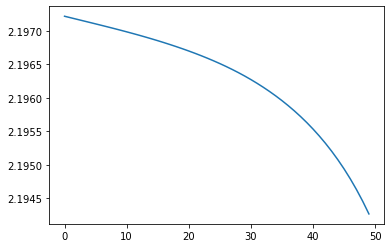

In [17]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

predictions = []
original_labels = []
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(vocab_token2id, row['content'])
        probs = model(bow_vec)
        # probs = tensor([[0.1110, 0.1091, 0.1108, 0.1121, 0.1134, 0.1075, 0.1149, 0.1107, 0.1105]]), tensor, tensor, ...
        predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_labels.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_labels, predictions))
df_loss_file = pd.read_csv(model_loss_file)

print(len(df_loss_file))
print(df_loss_file.columns)

history_loss = df_loss_file[' loss'].plot()
fig_loss = history_loss.get_figure()
fig_loss.savefig(OUTPUT_FOLDER + "loss.png")
